# Pneumonia Detection with VGG16

This notebook demonstrates how to detect instances of pneumonia in images of chest x-rays, using the pre-trained VGG16 deep learning model.

To get started, you must have the following requirements installed:

1. tensorflow - to preprocess data and work with the VGG16 model
2. numpy - to prepare data during testing
3. matplotlib - to display images in the Jupyter notebook
4. notebook - to run this notebook in a Jupyter server

It is recommended to have a virtual environment to isolate these requirements from the rest of your system. This can be done using Python's virtualenv package.

First, open a Terminal (Command Prompt on Windows) in the same folder as this notebook and create a virtual environment:

```shell
python3 -m venv env
```

Next, activate the virtual environment. For Windows users:

```shell
.\env\Scripts\activate
```

For Linux and MacOS users:

```shell
source env/bin/activate
```

Now you can safely install the above requirements in your virtual environment:

```shell
pip install tensorflow numpy matplotlib notebook
```

After installation is complete, launch the Jupyter server to edit this notebook:

```shell
jupyter notebook
```

## Getting Started

The following imports are necessary to work with this notebook:

In [28]:
# General imports

import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Tensorflow and Keras imports

from tensorflow import keras
from keras.models import Model
from keras.utils import load_img
from keras.models import load_model
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Lambda, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator

## Transfer Learning

<a href="https://www.ibm.com/topics/transfer-learning">IBM</a> defines transfer learning as:

***"Using pre-trained models from one machine learning task or dataset to improve performance and generalizability on a related task or dataset."***

While traditional machine learning focuses on creating new models for each new task, transfer learning allows using pre-trained models on new problems.

Transfer learning is particularly appealing for scenarios that require working with DNNs (Deep Neural Networks) and **deep learning**, because these often require processing massive quantities of structured and/or unstructured data, which requires time and is heavy on computational resources.

## The Data

For this notebook, we will be using a dataset available on Kaggle for pneumonia detection. It is a large collection of chest x-ray images divided into two classes:

1. `NORMAL` - for chest x-rays of healthy people
2. `PNEUMONIA` - for chest x-rays of pneumonia patients

The dataset can be found <a href="https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia">here</a>.

### Exploratory Data Analysis

First, we'll inspect how the dataset is structured.

In [10]:
!tree "./data" -d

./data
├── test
│   ├── NORMAL
│   └── PNEUMONIA
├── train
│   ├── NORMAL
│   └── PNEUMONIA
└── val
    ├── NORMAL
    └── PNEUMONIA

9 directories


As shown above, the dataset has been divided into 3 sub-directories:

1. `test` - testing data
2. `train` - training data
3. `val` - validation data

We can also inspect how many images belong to each class in the training, validation and testing data.

In [3]:
def count_images(directory):
    return sum(1 for _ in os.listdir(directory) if _.endswith(('.png', '.jpg', '.jpeg')))

def summarize_data(base_dir):
    return {split: {category: count_images(os.path.join(base_dir, split, category)) 
                    for category in ['NORMAL', 'PNEUMONIA']} 
            for split in ['train', 'val', 'test']}

base_dir = './data'
data_summary = summarize_data(base_dir)

for split, categories in data_summary.items():
    print(f'{split.capitalize()} data:')
    for category, count in categories.items():
        print(f'  {category}: {count} images')
    print()

Train data:
  NORMAL: 1341 images
  PNEUMONIA: 3875 images

Val data:
  NORMAL: 8 images
  PNEUMONIA: 8 images

Test data:
  NORMAL: 234 images
  PNEUMONIA: 390 images



Let's take a look at a single image to see what we're dealing with here:

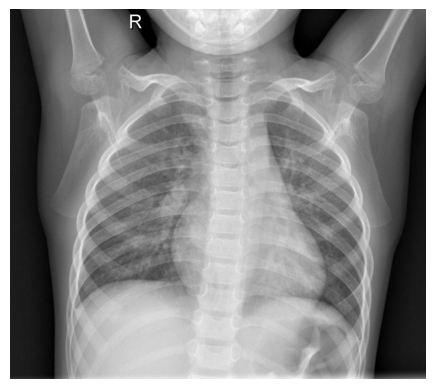

In [4]:
# Load chest-xray image from disk
img = mpimg.imread("./data/train/NORMAL/IM-0115-0001.jpeg")

# Display loaded image
%matplotlib inline
plt.imshow(
    img,
    cmap="gray",    # `cmap="gray"` used because Matplotlib uses the viridis color map by default
)
plt.axis("off")
plt.show()

The above chest x-ray was taken from a healthy person.

### Image Augmentation

When training deep learning models using images, it's always better to use lots of data, especially images with slight variations in them, which can help the model generalize better.

But if we have limited data available, we can apply **image augmentation** to expand our dataset.

Image augmentation is the process of applying different transformations on our existing images, which results in multiple transformed copies of the same image. Each copy differs from its original image through minor differences created using rotation, flipping, shift etc.

Keras allows us to do this using the `ImageDataGenerator` class. In our case, we can augment both the training and testing data with different augmentation criteria:

In [5]:
# Instantiate data generator for training data
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Instantiate data generator for testing data
test_datagen = ImageDataGenerator(rescale = 1./255)

Notice how we haven't applied as much transformations in `test_datagen` as we have in `train_datagen`. This is because we must keep our training data as close to real-world data as possible, without subjecting it to too much alterations.

Next, we can load the images using the `flow_from_directory()` function in these data generators.

In [6]:
# Load the training data via the training data generator
training_set = train_datagen.flow_from_directory(
    directory = './data/train',     # The folder which contains subfolders containing the training data.
    target_size = (224, 224),       # The size of the input images. Every image will be resized to this size.
    batch_size = 10,                # Number of images to be yielded by the generator per batch
    class_mode = 'categorical',     # The type of label arrays returned
)

# Load the testing data via the testing data generator
testing_set = test_datagen.flow_from_directory(
    directory = './data/test',      # The folder which contains subfolders containing the testing data.
    target_size = (224, 224),       # The size of the input images. Every image will be resized to this size.
    batch_size = 10,                # Number of images to be yielded by the generator per batch
    class_mode = 'categorical',     # The type of label arrays returned
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


When training the model, we can use `glob` to retrieve the paths of the directories containing the training data, separated as classes.

In [7]:
# Load sub-folders containing training data
folders = glob("./data/train/*")
print(folders)

['./data/train/PNEUMONIA', './data/train/NORMAL']


## The Model

For our problem of detecting pneumonia in chest x-rays, we will perform transfer learning on the pre-trained **VGG16** model.

### VGG16

Introduced by the Visual Geometry Group at the University of Oxford, the VGG16 model is a deep learning model built using the **Convolutional Neural Network** (CNN) architecture.

VGG16 is renowned for its simplicity and effectiveness, and is a popular choice for many **image classification** and **object detection** tasks. It features a depth of **16 layers**, which consists of

1. 13 **convolutional** layers - used for feature extraction
2. 3 **fully connected** (a.k.a. **dense**) layers - used for the actual classification

Technically, VGG16 models have 21 layers as they also have 5 **max-pooling** layers, but only the convolutional and fully-connected layers are weight layers.

Despite being smaller than more recent architectures (e.g. the ResNet family of models), VGG16 is widely used due to its strong performance and versatility.

The architecture of VGG16 is shown below:

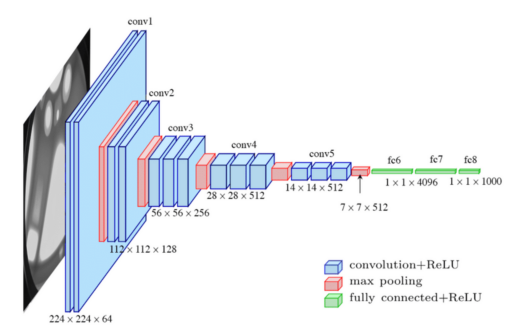

In [8]:
# Load architecture image from disk
img = mpimg.imread("./img/vgg16.png")

# Display loaded image
%matplotlib inline
plt.imshow(img)
plt.axis("off")
plt.show()

VGG16 can be found as part of the **Keras Applications** package, which is a collection of deep learning models along with pre-trained weights. To perform transfer learning on the pneumonia detection business case, we will load the VGG16 model from `keras.applications`, pre-trained on the **ImageNet dataset**.

When we are loading the model, we must **exclude the final fully connected layer**. This is because we want to fine-tune the final layer for our specific task - in this case, pneumonia detection.

In [9]:
# Load the VGG16 model

vgg = VGG16(
    input_shape=(224, 224, 3),    # Specify input image properties, i.e. 224px by 224px, 3 color channel (RGB)
    weights='imagenet',           # Load the pre-trained weights of the ImageNet dataset
    include_top=False,            # Exclude the final fully connected layer
)

To ensure that the pretrained layers of the VGG16 model do not lose their knowledge during transfer learning, we must **freeze** them. This prevents them from learning new knowledge (by ensuring that their weights aren't updated during a training run).

In [10]:
for layer in vgg.layers:
    layer.trainable = False

We do this step before attaching any new layers to the model (which must be trained on the data related to our business case).

Before we connect any new dense layers to be trainined on the image classification task, we need to add a **Flatten** layer. It reshapes the output of the preceding layer into a one-dimensional vector, which dense (fully connected) layers can work on. Flatten layers do not contain any weights, and are not changed during training.

It acts as a bridge between convolution/pooling layers (which work with 3D tensors) and dense layers.

In [11]:
# Instantiate flatten layer
flatten_layer = Flatten()

# Add flatten layer after VGG16's current output layer (final convolutional/pooling layer)
x = (flatten_layer)(vgg.output)

Next, we can add a dense layer after the flatten layer to provide the output (prediction) made by the model.

This layer is trainable, and learns from the pneumonia dataset during training.

In [12]:
# Instantiate dense layer
dense_layer = Dense(
    units=len(folders),     # The dimensionality of the output space (in this case, 2)
    activation="softmax",   # The activation function of the neurons in the layer
)

# Add dense layer after flatten layer to get model output
prediction = (dense_layer)(x)

Finally, we can combine the pre-trained layers of the VGG16 model with the flatten and dense layers we created. This produces the final model which can be trained for our specific scenario.

In [13]:
# Instantiate model with VGG16's pre-trained layers and the custom flattened and dense layers
model = Model(
    inputs=vgg.input,
    outputs=prediction,
)

# View the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Here, we can notice our custom flatten and dense layers connected with the frozen layers of the VGG16 model.

Finally, we configure the model for training, i.e. compile the model by specifying the optimizer and loss function to be used, as well as the metrics required to be measured.

In [14]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

### Model Training

Now, we can train this model by loading data via the data generators.

For this, we use the `Model.fit()` function from Keras. This function returns a `History` object, whose `History.history` attribute is a record of training loss values and metrics values at successive epochs.

We will train our model for just 1 epoch (for demonstration purposes).

In [17]:
# Train the model using the augmented data
history = model.fit(
    training_set,
    validation_data=testing_set,
    epochs=1,
    steps_per_epoch=len(training_set),
    validation_steps=len(testing_set)
)

522/522 [==============================] - 654s 1s/step - loss: 0.1554 - accuracy: 0.9548 - val_loss: 0.4261 - val_accuracy: 0.9071


We can notice that the model has achieved an accuracy of **95.48%** and loss of **15.54%** during the first epoch.

### Model Testing

We can test the performance of the model manually by checking its performance on a single image from the testing dataset.

We can use the `load_image()` function from `keras.utils` to load a testing image.

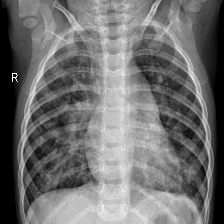

In [27]:
# Load a single image from the testing dataset
img = load_img(
    path="./data/test/PNEUMONIA/person15_virus_46.jpeg",
    target_size=(224, 224)
)

img

Next, we need to convert this into a NumPy array, which is the format supported by Keras models as input.

In [32]:
# Convert testing image into a NumPy array
x = img_to_array(img)

x

array([[[ 0.,  0.,  0.],
        [18., 18., 18.],
        [39., 39., 39.],
        ...,
        [34., 34., 34.],
        [27., 27., 27.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [20., 20., 20.],
        [27., 27., 27.],
        ...,
        [36., 36., 36.],
        [19., 19., 19.],
        [ 1.,  1.,  1.]],

       [[ 0.,  0.,  0.],
        [ 2.,  2.,  2.],
        [22., 22., 22.],
        ...,
        [28., 28., 28.],
        [ 5.,  5.,  5.],
        [ 0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]

After this, we have to change the shape of the image array by **expanding its dimensions**.

Here, we convert the array from `(224, 224, 3)` to `(1, 224, 224, 3)` by adding a new dimension to the array. This new dimension is necessary to store the batch size of the inputs to be provided to the model.

For our case, we will be using a single image for testing, so we can specify a batch size of `1`.

In [33]:
# Expand dimensions of image array to accommodate for batch size
x = np.expand_dims(
    a=x,
    axis=0,
)

x

array([[[[ 0.,  0.,  0.],
         [18., 18., 18.],
         [39., 39., 39.],
         ...,
         [34., 34., 34.],
         [27., 27., 27.],
         [ 0.,  0.,  0.]],

        [[ 0.,  0.,  0.],
         [20., 20., 20.],
         [27., 27., 27.],
         ...,
         [36., 36., 36.],
         [19., 19., 19.],
         [ 1.,  1.,  1.]],

        [[ 0.,  0.,  0.],
         [ 2.,  2.,  2.],
         [22., 22., 22.],
         ...,
         [28., 28., 28.],
         [ 5.,  5.,  5.],
         [ 0.,  0.,  0.]],

        ...,

        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.],
        

Each Keras Application expects a specific kind of preprocessing done on its input before performing inference.

Thus, we must apply preprocessing steps that are, by default, required by models that are created from VGG16 in Keras Applications. For this, we use `preprocess_input()` from `keras.applications.vgg16`.

In [34]:
# Preprocess the image array as required by VGG16 from Keras Applications

img_data = preprocess_input(x)

img_data

array([[[[-103.939, -116.779, -123.68 ],
         [ -85.939,  -98.779, -105.68 ],
         [ -64.939,  -77.779,  -84.68 ],
         ...,
         [ -69.939,  -82.779,  -89.68 ],
         [ -76.939,  -89.779,  -96.68 ],
         [-103.939, -116.779, -123.68 ]],

        [[-103.939, -116.779, -123.68 ],
         [ -83.939,  -96.779, -103.68 ],
         [ -76.939,  -89.779,  -96.68 ],
         ...,
         [ -67.939,  -80.779,  -87.68 ],
         [ -84.939,  -97.779, -104.68 ],
         [-102.939, -115.779, -122.68 ]],

        [[-103.939, -116.779, -123.68 ],
         [-101.939, -114.779, -121.68 ],
         [ -81.939,  -94.779, -101.68 ],
         ...,
         [ -75.939,  -88.779,  -95.68 ],
         [ -98.939, -111.779, -118.68 ],
         [-103.939, -116.779, -123.68 ]],

        ...,

        [[-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         ...,
         [-103.939, -116.779, -123.68 ],
         [-103.939, -1

This performs two preprocessing actions mainly:

1. Converting the input image from **RGB to BGR**.
2. Zero-centering each color channel (with respect to the ImageNet dataset), without any scaling.

Finally, we can call `Model.predict()` on the trained model to get predictions.

In [35]:
# Get predictions from the trained model on the testing image
predictions = model.predict(img_data)

1/1 [==============================] - 1s 545ms/step


To view the class predicted by the model for this image, we can access the element having `[0][0]` index in the `predictions` tensor.

In [39]:
# Retrieve the predicted class

result = int(predictions[0][0])

if result == 0:
    print("Person is affected by pneumonia.")
else:
    print("Person is healthy.")

Person is affected by pneumonia.


Since we used a testing image from the `PNEUMONIA` class, we can see that the model has performed accurately on this image.

### Model Saving and Loading

Once we are satisfied with a model's performance after testing, we can save the model to ensure its **persistence**, i.e. freeze the model's weights so that it can be used elsewhere.

For this, we use the `Model.save()` of the model object.

In [19]:
# Save the model into a `.h5` file
model.save("vgg16-chest-xray.h5")

/home/ravindu-aratchige/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


To work with this model again, we can use `keras.models.load_model()`.

In [22]:
# Load the frozen model back into memory
model = load_model("vgg16-chest-xray.h5")

print(model)